# Project Objective

**Context** 

- The datasets for this project come from Zyfra, an actual company that works on improving the efficiency and safety of the mining, oil & gas, chemical and engineering industries.

**Main Objective** 

- Our main objective with this project is to provide to Zyfra a machine learning model that can predict the amount of pure gold extracted from gold ore.

**Project Structure**

The Project will be composed of 3 main sections:
1. Data Pre-processing and Preparation
2. EDA and Data Quality Check
3. Developing and Building the ML model

**Data Descriptions**

Through studying the gold mining process and treatment of the ores to get to the pure gold, and with the data dictionary provided, the data follows this structure: 

 - [stage].[parameter_type].[parameter_name]
 - final.output.concentrate_au, for example. These define the column names, so we understand what data we want and how to get it.


## Data Pre-Processing and Preparation

Let's begin by loading the libraries and datasets, and taking a general look at it. Here, our main objectives are:
 - Check if the withdrawn quantity was calculated correctly.
 - Analyse the train versus test datasets for consistency.
 - Pre-Process the data (check for duplicates, invalid data, data types...)

In [1]:
#Loading Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

In [2]:
#Loading Datasets
gold_rec_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_rec_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_rec_full = pd.read_csv('/datasets/gold_recovery_full.csv')

### Checking formula calculation

Alright, let's check if the withdrawn values were calculated correctly. The variables and formula are as follows:

 - C  is the proportion of gold in the concentrate after flotation (for finding the initial withdrawal from the rough concentrate) or after purification (for finding the final withdrawal from the concentrate).
 
 
 - F is the proportion of gold fed into the system before flotation
 
 
 - T is the proportion of gold in the tailings (remaining ore) after flotation (for finding the initial withdrawal from the rough concentrate) or after purification (for finding the final withdrawal from the concentrate).


And the formula:

Withdrawal = (C*(F-T)) / (F*(C-T))


To test the formula, we'll use the training dataset, and we'll run it in the following columns:
 - rougher.output.concentrate_au = C
 - rougher.input.feed_au = F
 - rougher.output.tail_au = T

And compare the results with `rougher.output.recovery`.

In [3]:
def formula_checking(data, C1, F1, T1, R1):
    
    #defining variables
    C = data[C1]
    F = data[F1]
    T = data[T1]
    
    #creating dataset to check
    denominator = F * (C - T)
    
    #Check for zero denominator
    recovery_formula = np.where(denominator == 0, 0, (C * (F - T)) / denominator * 100)
    
    recovery_data = data[R1]
    
    formula_check = pd.DataFrame()

    formula_check['rec_formula'] = recovery_formula
    formula_check['rec_data'] = recovery_data
    
    #MSE for evaluation
    formula_check = formula_check.dropna()
    MSE = mean_squared_error(formula_check['rec_data'], formula_check['rec_formula'])
    
    return formula_check, MSE 

In [4]:
comp_data, MSE_data = formula_checking\
(gold_rec_train,'rougher.output.concentrate_au','rougher.input.feed_au','rougher.output.tail_au','rougher.output.recovery')

display(comp_data.head())
print('MSE:', MSE_data)

,rec_formula,rec_data
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


MSE: 1.9707770226270568e-28


The formula outputs matches the data we have for recovery up to 10 decimals, which means it is correct, the recovery value has been calculated properly. As we can observe, the MSE is also incredibly small, meaning the deviations are minimal. Let's run the function for the final data now.

In [5]:
comp_data_f, MSE_data_f = formula_checking\
(gold_rec_train,'final.output.concentrate_au','rougher.input.feed_au','final.output.tail_au','final.output.recovery')

display(comp_data_f.head())
print('MSE:', MSE_data_f)

,rec_formula,rec_data
0,70.541216,70.541216
1,69.266198,69.266198
2,68.116445,68.116445
3,68.347543,68.347543
4,66.927016,66.927016


MSE: 1.4922465706685706e-28


The MSE between the calculated values and the observed ones is minimal. Let's keep moving, but let's see if we can increase the data we have for the final output with the formula.

In [6]:
#Checking amount of missing values in final output recovery
gold_rec_full['final.output.recovery'].isna().sum()

1963

In [7]:
#formula to fill values
def formula_fill_final(row):
    
    #defining variables
    C = row['final.output.concentrate_au']
    F = row['rougher.input.feed_au']
    T = row['final.output.tail_au']
    
    #creating rowset to check
    denominator = F * (C - T)
    
    #Check for zero denominator
    if denominator == 0:
        recovery_value = np.nan  # Set to NaN when denominator is zero
    else:
        recovery_value = (C * (F - T)) / denominator * 100
    
    return recovery_value


In [8]:
#applying formula
gold_rec_full['final.output.recovery'] = gold_rec_full.apply(formula_fill_final, axis = 1)

In [9]:
#checking if it worked
gold_rec_full['final.output.recovery'].isna().sum()

1767

We were able to recover a few data points with this. Let's keep moving.

### Train versus Test datasets

Our aim here is to find if there are missing data points in the test or train datasets and make necessary corretions.

In [10]:
#Overview of data

#gold_rec_train
display(gold_rec_train.head(2))
print(gold_rec_train.info())
print()

#gold_rec_test
display(gold_rec_test.head(2))
print(gold_rec_test.info())
print()

#gold_rec_full
display(gold_rec_full.head(2))
print(gold_rec_full.info())
print()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.08,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.08,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20949 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


Right from the outset we see that the train dataset has many more columns than the test dataset. Which columns are those?

In [11]:
#which are the missing columns?
cols_missing = set(gold_rec_train.columns) - set(gold_rec_test.columns)
cols_missing = list(cols_missing)

print(cols_missing)

['primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 'final.output.tail_pb', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.output.tail_au', 'final.output.concentrate_ag', 'rougher.calculation.au_pb_ratio', 'secondary_cleaner.output.tail_ag', 'final.output.tail_sol', 'primary_cleaner.output.concentrate_sol', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_ag', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.concentrate_pb', 'primary_cleaner.output.tail_pb', 'rougher.output.recovery', 'final.output.concentrate_sol', 'rougher.output.tail_sol', 'final.output.tail_ag', 'final.output.concentrate_pb', 'final.output.recovery', 'rougher.output.tail_ag', 'rougher.output.concentrate_au', 'secondary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_au', 'secondary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_ag', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'final.output.tail_au', 'rougher.output.t

**Summary**

We were informed upon receiving the dataset that some of the information present in the training dataset was measured/calculated much later. This leads me to believe that the data missing in the test dataset is actually data which we won't have access to until much later in the process.

What this means is that, for the prediction model, we can only use the data present in the test dataset, since all the other data will only show up much later, and thus cannot be used promptly in the machine learning model to predict the final pure gold output of a rough ore input in the beginning. Using the full data of the train dataset would result in 'target leakage'. The only thing we'll add to this is the objective, `final.output.recovery`.

Target leakage occurs when the data used to train a model contains information that would not be available in a real-world scenario, making the model's predictions seem better than they actually are. By using only the data columns available in the test dataset, we prevent target leakage.

**Next Steps**

What we'll do now is get the full dataset and rid it of the extra columns we have in the training dataset versus the test dataset. Then we'll proceed with data pre-processing - remove duplicates and missing values.

### Data Cleaning

In [12]:
#Producing dataset that prevents target leakage
cols_missing.remove('final.output.recovery')
df = gold_rec_full.drop(cols_missing, axis = 1)

cols_missing.append('final.output.recovery')
cols_missing.remove('rougher.output.recovery')
df_r = gold_rec_full.drop(cols_missing, axis = 1)

In [13]:
#Checking for missing and duplicated values
print('Final df')
print(df.isna().sum())
print('Duplicates:', df.duplicated().sum())
print(len(df))

print()
print('Rougher df')
print(df_r.isna().sum())
print('Duplicates:', df_r.duplicated().sum())
print(len(df_r))

Final df
date                                             0
final.output.recovery                         1767
primary_cleaner.input.sulfate                 1609
primary_cleaner.input.depressant              1546
primary_cleaner.input.feed_size                  0
primary_cleaner.input.xanthate                1151
primary_cleaner.state.floatbank8_a_air          56
primary_cleaner.state.floatbank8_a_level        49
primary_cleaner.state.floatbank8_b_air          56
primary_cleaner.state.floatbank8_b_level        43
primary_cleaner.state.floatbank8_c_air          54
primary_cleaner.state.floatbank8_c_level        43
primary_cleaner.state.floatbank8_d_air          55
primary_cleaner.state.floatbank8_d_level        43
rougher.input.feed_ag                           98
rougher.input.feed_pb                          244
rougher.input.feed_rate                        553
rougher.input.feed_size                        439
rougher.input.feed_sol                         359
rougher.input.feed_au 

In [14]:
df = df.dropna()
print(len(df))
print()
df_r = df_r.dropna()
print(len(df_r))

18772

18012


We had to drop about 20% of our datasets, but the data is now clean and ready to be analyzed. Now, we split the data between train and test, target and features. Let's just check first what columns we'll use for features and drop the ones that won't be useful.

In [15]:
#dropping columns not needed for ML training
df = df.drop('date', axis = 1)
df_r = df_r.drop('date', axis = 1)

In [16]:
#Features and Targets split

df_target = df['final.output.recovery']
df_features = df.drop('final.output.recovery', axis = 1)

df_target_r = df_r['rougher.output.recovery']
df_features_r = df_r.drop('rougher.output.recovery', axis = 1)

In [17]:
#Train & Test split final
df_train_feat, df_test_feat, df_train_targ, df_test_targ = \
train_test_split(df_features, df_target, test_size = 0.25, random_state = 1)


#Train & Test split rougher
df_train_feat_r, df_test_feat_r, df_train_targ_r, df_test_targ_r = \
train_test_split(df_features_r, df_target_r, test_size = 0.25, random_state = 1)

## EDA - Data Analysis

Alright, so for this section, we'll consider the full dataset we received from the customer, `gold_rec_full`.

### Compound Concentration Varying by Stage

Here we'll check the difference in concentration of the output metals by purification stage.

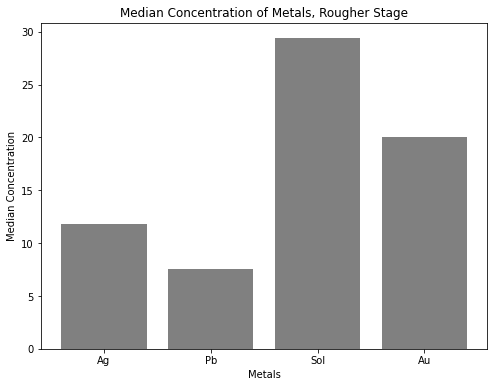

In [18]:
metals = ['Ag', 'Pb', 'Sol', 'Au']
ag = gold_rec_full['rougher.output.concentrate_ag'].median()
pb = gold_rec_full['rougher.output.concentrate_pb'].median()
sol = gold_rec_full['rougher.output.concentrate_sol'].median()
au = gold_rec_full['rougher.output.concentrate_au'].median()

medians = [ag, pb, sol, au]

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(metals, medians, color='grey')

# Add labels and title
plt.xlabel('Metals')
plt.ylabel('Median Concentration')
plt.title('Median Concentration of Metals, Rougher Stage')

# Show the plot
plt.show()

It seems that in the first stage, the greatest concentration is for `Sol`, followed by `Au`. Let's see how this changes thoughout the stages.

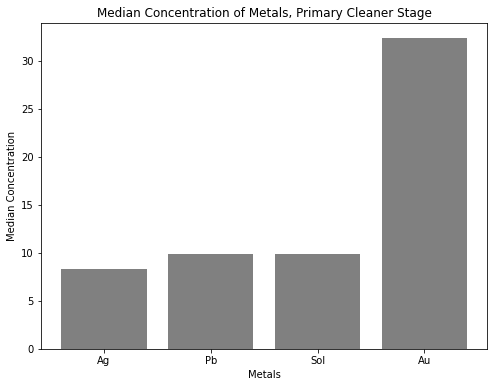

In [19]:
ag = gold_rec_full['primary_cleaner.output.concentrate_ag'].median()
pb = gold_rec_full['primary_cleaner.output.concentrate_pb'].median()
sol = gold_rec_full['primary_cleaner.output.concentrate_sol'].median()
au = gold_rec_full['primary_cleaner.output.concentrate_au'].median()

medians = [ag, pb, sol, au]

plt.figure(figsize=(8, 6))
plt.bar(metals, medians, color='grey')

# Add labels and title
plt.xlabel('Metals')
plt.ylabel('Median Concentration')
plt.title('Median Concentration of Metals, Primary Cleaner Stage')

# Show the plot
plt.show()

Here we see a large increase in Au, and large reductions in Sol. Slight increase for Pb and small decrease for Ag.

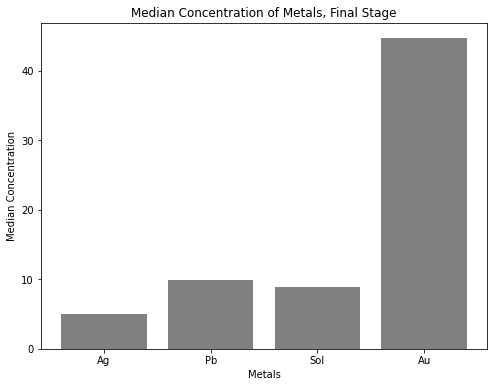

In [20]:
ag = gold_rec_full['final.output.concentrate_ag'].median()
pb = gold_rec_full['final.output.concentrate_pb'].median()
sol = gold_rec_full['final.output.concentrate_sol'].median()
au = gold_rec_full['final.output.concentrate_au'].median()

medians = [ag, pb, sol, au]

plt.figure(figsize=(8, 6))
plt.bar(metals, medians, color='grey')

# Add labels and title
plt.xlabel('Metals')
plt.ylabel('Median Concentration')
plt.title('Median Concentration of Metals, Final Stage')

# Show the plot
plt.show()

And then, on the final stage, concentrations of all other compounds fall a bit, and Au concentration increases significantly. Au concentrations start at around 20 in the rougher stage, and increase to 30 in the primary cleaner stage, reaching more than 40 in the final stage, while all other compounds fall in concentration.

### Comparing the ore particle size distributions in the training dataset and the test dataset

Let's check if the the training and test datasets we have created from the full dataset have good ore size distributions, as measured by the `rougher.input.feed_size`. We'll build a histogram for both, and check if they are similarly distributed.

We'll then compare that with the original datasets provided for training and testing.

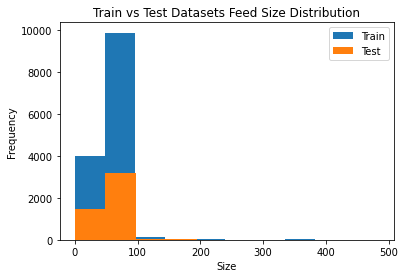

In [21]:
#Plotting train dataset feed_size
df_train_feat['rougher.input.feed_size'].plot(kind = 'hist', label = 'Train')
df_test_feat['rougher.input.feed_size'].plot(kind = 'hist', label = 'Test')
plt.xlabel('Size')
plt.title('Train vs Test Datasets Feed Size Distribution')
plt.legend()
plt.show()

What we see above are the distributions of ore feed sizes in the train and test datasets that we created through the original full dataset the customer sent us. We observe the following:
 - The distribution is very similar
 - There are a few very large values in the dataset

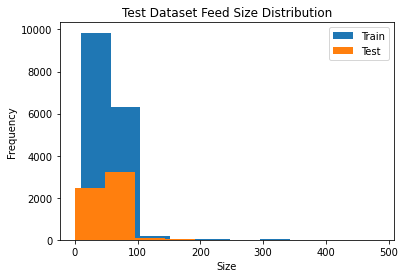

In [22]:
#Plotting train dataset feed_size
gold_rec_train['rougher.input.feed_size'].plot(kind = 'hist', label = 'Train')
gold_rec_test['rougher.input.feed_size'].plot(kind = 'hist', label = 'Test')
plt.xlabel('Size')
plt.title('Test Dataset Feed Size Distribution')
plt.legend()
plt.show()

This one compares the distribution of ore sizes between the test and train datasets that we received. As we can observe, the distributions are not that similar, and therefore this could cause problems when training our machine learning model.

We'll stick to the datasets we created through the original full dataset.

## Building the Model

The final section of the project. Our aim here is to accomplish the following:
1. Build a function to calculate the sMAPE (symetric Mean Absolute Percentage Error)
2. Train different models, evaluate them using cross-validation and sMAPE. Pick the best model, test it.

In [23]:
#Building the sMAPE fucntion
def smape(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    #Calculate the absolute percentage error for each data point
    absolute_percentage_error = np.abs((y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))
    
    #Handle cases where y_true is 0 by setting the error to 0
    absolute_percentage_error[np.isnan(absolute_percentage_error)] = 0
    
    #Calculate the mean sMAPE
    smape = np.mean(absolute_percentage_error) * 100
    
    return smape

In [24]:
def smape_final(smape_rougher, smape_final):
    smape_fin = 0.25*smape_rougher + 0.75*smape_final
    return smape_fin

Now that we have our sMAPE function, let's get to the model building. First, we have to scale the data.

In [25]:
#scaling the data

#Create a StandardScaler instance
scaler = StandardScaler()

#Fit the scaler to the training data and transform it
df_train_feat_scaled = scaler.fit_transform(df_train_feat)

# Use the same scaler to transform the test data
df_test_feat_scaled = scaler.transform(df_test_feat)

# Scaling rougher df too
scaler_r = StandardScaler()

df_train_feat_r_scaled = scaler_r.fit_transform(df_train_feat_r)
df_test_feat_r_scaled = scaler_r.transform(df_test_feat_r)

**Linear Regression Model Test**

In [26]:
#Training LinearRegression Model
model0 = LinearRegression()
model0_r = LinearRegression()

#rougher
model0_r.fit(df_train_feat_r_scaled, df_train_targ_r)
y_pred0_r = model0_r.predict(df_test_feat_r_scaled)


#final
model0.fit(df_train_feat_scaled, df_train_targ)
y_pred0 = model0.predict(df_test_feat_scaled)

In [27]:
#Eval metrics
smape_rougher0 = smape(df_test_targ_r, y_pred0_r)
smape_fin0 = smape(df_test_targ, y_pred0)
print(smape_final(smape_rougher0, smape_fin0))

print()
lin_reg_model = LinearRegression()
print('Cross-Validation Scores Mean:', cross_val_score(lin_reg_model, df_train_feat_scaled, df_train_targ, cv=3).mean())

72.85850242932499

Cross-Validation Scores Mean: 0.005939954820946373


The SMAPE for the Linear Regression Model is at 72%, which means that it predicts the values with an average error of almost 72%. This model is out. Let's test some others.

**Random Forest Regressor**

In [28]:
%%time

#Random Forest Rougher
model1_r = RandomForestRegressor(n_estimators=100, random_state=1)
model1_r.fit(df_train_feat_r_scaled, df_train_targ_r)
y_pred1_r = model1_r.predict(df_test_feat_r_scaled)


#Random Forest Final
model1 = RandomForestRegressor(n_estimators=50, random_state=1)
model1.fit(df_train_feat_scaled, df_train_targ)
y_pred1 = model1.predict(df_test_feat_scaled)

CPU times: user 2min 58s, sys: 285 ms, total: 2min 58s
Wall time: 2min 59s


In [29]:
%%time
#Eval
smape_rougher1 = smape(df_test_targ_r, y_pred1_r)
smape_fin1 = smape(df_test_targ, y_pred1)
print(smape_final(smape_rougher1, smape_fin1))

random_forest_val = RandomForestRegressor(n_estimators=50, random_state=1)
print('Cross-Validation Scores Mean:', cross_val_score(random_forest_val, df_train_feat_scaled, df_train_targ, cv=3).mean())

7.680156904556854


/tmp/ipykernel_44/1007584637.py:7: RuntimeWarning: invalid value encountered in true_divide
  absolute_percentage_error = np.abs((y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))


Cross-Validation Scores Mean: 0.20914209639238712
CPU times: user 2min 12s, sys: 120 ms, total: 2min 12s
Wall time: 2min 12s


With a much better SMAPE than the Linear Regression model, the Random Forest is a serious contender. Let's check one last model, LightGBM, which should run faster than the Random Forest model and might yield similar results.

**LightGBM**

In [30]:
%%time

#LightGBM
params = {
    'num_leaves': 31,
    'learning_rate': 0.05,
    'n_estimators': 20,
    'max_depth': -1,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'objective': 'regression',
    'metric': 'mse',
    'random_state': 1
}


#Rougher
lgb_model_r = lgb.LGBMRegressor(**params)
lgb_model_r.fit(df_train_feat_r_scaled, df_train_targ_r)
y_pred2_r = lgb_model_r.predict(df_test_feat_r_scaled)

#Final
lgb_model = lgb.LGBMRegressor(**params)
lgb_model.fit(df_train_feat_scaled, df_train_targ)
y_pred2 = lgb_model.predict(df_test_feat_scaled)

CPU times: user 1.33 s, sys: 11.5 ms, total: 1.35 s
Wall time: 1.37 s


In [31]:
#Eval
smape_rougher2 = smape(df_test_targ_r, y_pred2_r)
smape_fin2 = smape(df_test_targ, y_pred2)
print(smape_final(smape_rougher2, smape_fin2))

print()
lgb_model_val = lgb.LGBMRegressor(**params)
print('Cross-Validation Scores Mean:', cross_val_score(lgb_model_val, df_train_feat_scaled, df_train_targ, cv=3).mean())

11.329913772303703

Cross-Validation Scores Mean: 0.11228998440661282


## Final Model Selection and Tuning Hyperparameters

**Summary**

By analyzing the SMAPE scores and the cross validation scores from all 3 models tested, here is what we observe:
 1. Linear Regression model is out of question: terrible performance.
 2. Random Forest: Best scores both in the cross validation as in the SMAPE, but takes the longest to load.
 3. LightGBM: Incredibly fast and almost as accurate as the Random Forest.
 
**Final Selection**
The final model selection will be the Random Forest. The reason for this is that for the data we are trying to predict, accuracy matters more than speed, and the Random Forest model is more accurate, despite being the slowest, it is the best choice for the task at hand. **It can predict the gold recovery amount with less than 8% error.**

With this, the final step is to tune the hyperparameters of both Random Forest models, the one that predicts the rougher output recovery and the one that predicts the final output recovery. And all of this was done avoiding target leakage.

In [32]:
%%time
#Tuning rougher model hyperparameters


param_grid = {
    'n_estimators': [50, 100]     
}

#Create the RandomForestRegressor model
model1_r = RandomForestRegressor(random_state=1)

#Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model1_r, param_grid=param_grid, cv=2, n_jobs=-1, scoring='neg_mean_squared_error')

#Fit the grid search to your data
grid_search.fit(df_train_feat_r_scaled, df_train_targ_r) 

#Get the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

#Print the best parameters and best score (negative mean squared error)
print("Best Parameters:", best_params)
print("Best Negative Mean Squared Error:", -grid_search.best_score_)

Best Parameters: {'n_estimators': 100}
Best Negative Mean Squared Error: 85.90998104371909
CPU times: user 4min 8s, sys: 100 ms, total: 4min 8s
Wall time: 4min 8s


In [ ]:
%%time
#Tuning final model hyperparameters


param_grid = {
    'n_estimators': [50, 100]   
}

#Create the RandomForestRegressor model
model1 = RandomForestRegressor(random_state=1)

#Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model1, param_grid=param_grid, cv=2, n_jobs=-1, scoring='neg_mean_squared_error')

#Fit the grid search to your data
grid_search.fit(df_train_feat_scaled, df_train_targ) 

#Get the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

#Print the best parameters and best score (negative mean squared error)
print("Best Parameters:", best_params)
print("Best Negative Mean Squared Error:", -grid_search.best_score_)

We have tuned only 1 hyperparameter due to time constraints. These can be further tuned as needed.

**Final Product**

- For rougher output recovery prediction, use `model1_r`
- For final output recovery, use `model1`

**Key Takeaways**

Our model can predict how much gold is going to be recovered based on the parameters set for the machines before placing the gold ore inside the extractor, with only about 8% error in the recovery value.

**With our model, the customer can fine-tune their extractor parameters to maximize gold extraction.**